## 11/13 Notebook to be converted to a script to run tests of mpasregions package
### This notebook is used to test the transect sorting algorithms. This requires consideration for transects created from algorithms and for transects created form an initial geojson mask file. 

In [19]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
#Packages 
import numpy as np
import xarray as xr
import cmocean.cm as cmo
import matplotlib.pyplot as plt
import mpas_tools

from geometric_features import GeometricFeatures
from geometric_features import read_feature_collection

from mpas_tools.mesh.mask import compute_mpas_region_masks
from mpas_tools.parallel import create_pool
from mpas_tools.io import write_netcdf

import geojson
import json
import mosaic
import os.path
import mpasregions.sections as mps
import gsw
import warnings 
import glob
from xgcm import Grid

### create dataset

In [21]:
# I actually think that you will need to somehow define cells to be nans to represent land (or at least for cellsOnEdge)... 
# And then you remove the edges and vertices that would be captured within those cells...? 

lonCells = np.array([180.,  90., 270.])
latCells = np.array([-36.,  36.,  36.])

lonEdges = np.array([135., 235.,  90., 270.,  45., 135., 225., 315.,   0., 180., 45., 135., 225., 315.])
latEdges = np.array([-72., -72., -36., -36.,   0.,   0.,   0.,   0.,  36.,  36., 72.,  72.,  72.,  72.])

lonVertices = np.array([180.,  90., 270.,  90., 270.,   0., 180.,   0., 180., 90., 270.])
latVertices = np.array([-90., -54., -54., -18., -18.,  18.,  18.,  54.,  54., 90.,  90.])

ds = xr.Dataset({},coords={
    'nCells':xr.DataArray(np.arange(0,len(lonCells)), dims='nCells'),
    'nEdges': xr.DataArray(np.arange(0,len(lonEdges)), dims='nEdges'),
    'nVertices':xr.DataArray(np.arange(0,len(lonVertices)), dims='nVertices')
})

ds['lonCell'] = xr.DataArray(np.deg2rad(lonCells), dims='nCells')
ds['latCell'] = xr.DataArray(np.deg2rad(latCells), dims='nCells')
ds['lonEdge'] = xr.DataArray(np.deg2rad(lonEdges), dims='nEdges')
ds['latEdge'] = xr.DataArray(np.deg2rad(latEdges), dims='nEdges')
ds['lonVertex'] = xr.DataArray(np.deg2rad(lonVertices), dims='nVertices')
ds['latVertex'] = xr.DataArray(np.deg2rad(latVertices), dims='nVertices')

xr_edgesOnVertex =  np.array([
    [0,1,np.nan], # on vertex 0
    [0,2,np.nan], # on vertex 1
    [1,3,np.nan], # on vertex 2
    [2,4,5], # on vertex 3
    [3,6,7], # on vertex 4
    [4,7,8], # on vertex 5
    [5,6,9], # on vertex 6
    [8,10,13], # on vertex 7
    [9,11,12], # on vertex 8
    [10,11,np.nan], # on vertex 9
    [12,13,np.nan] # on vertex 10
])

n_edgesOnVertex = mps.xr_to_n_idx(xr_edgesOnVertex)
n_edgesOnVertex[np.isnan(n_edgesOnVertex)] = 0 # extra vertices that were once nans are now zeros

ds['edgesOnVertex'] = xr.DataArray(np.int32(n_edgesOnVertex), dims = ('nVertices','vertexDegree'))
# ds['edgesOnVertex'] = ds.edgesOnVertex.where(ds.edgesOnVertex > 0)
# ds.edgesOnVertex

xr_verticesOnEdge = np.array([
    [0,1], # on edge 0
    [0,2], # on edge 1
    [1,3], # on edge 2
    [2,4], # on edge 3
    [3,5], # on edge 4
    [3,6], # on edge 5
    [4,6], # on edge 6
    [4,5], # on edge 7
    [5,7], # on edge 8
    [6,8], # on edge 9
    [7,9], # on edge 10
    [8,9], # on edge 11
    [8,10], # on edge 12
    [7,10] # on edge 13
    
])

n_verticesOnEdge = mps.xr_to_n_idx(xr_verticesOnEdge)
ds['verticesOnEdge'] = xr.DataArray(np.int32(n_verticesOnEdge), dims=('nEdges', 'TWO'))

xr_cellsOnEdge = np.array([
    [0,np.nan], # on edge 0
    [0,np.nan], # on edge 1
    [0,np.nan], # on edge 2
    [0,np.nan], # on edge 3
    [1,np.nan], # on edge 4
    [0,1],  # on edge 5
    [0,2],  # on edge 6
    [2,np.nan], # on edge 7
    [1,2],  # on edge 8
    [1,2],  # on edge 9
    [1,np.nan], # on edge 10
    [1,np.nan], # on edge 11
    [2,np.nan], # on edge 12
    [2,np.nan] #on edge 13
])

n_cellsOnEdge = mps.xr_to_n_idx(xr_cellsOnEdge)
n_cellsOnEdge[np.isnan(n_cellsOnEdge)] = 0
ds['cellsOnEdge'] = xr.DataArray(np.int32(n_cellsOnEdge), dims=('nEdges', 'TWO'))


ds['VertexID'] = mps.xr_to_n_idx(ds.nVertices)
ds = ds.assign_coords({'VertexID': mps.xr_to_n_idx(ds.nVertices)})

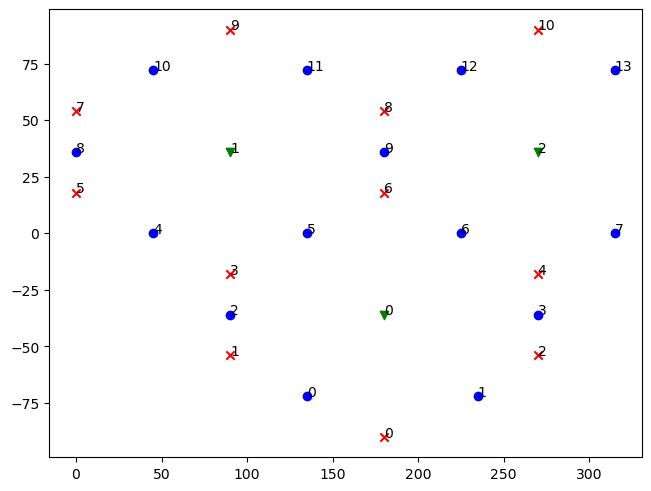

In [22]:
fig,ax=plt.subplots(nrows=1,ncols=1,constrained_layout=True)
ax.scatter(np.rad2deg(ds.lonEdge),np.rad2deg(ds.latEdge),color='blue')
ax.scatter(np.rad2deg(ds.lonVertex),np.rad2deg(ds.latVertex),marker='x',color='red')
ax.scatter(np.rad2deg(ds.lonCell), np.rad2deg(ds.latCell),marker='v',color='green')
nEdges = ds.nEdges.values
nVertices = ds.nVertices.values
nCells = ds.nCells.values

for i, txt in enumerate(nEdges):
    ax.annotate(txt, (np.rad2deg(ds.lonEdge[i]),np.rad2deg(ds.latEdge[i])))

for i, txt in enumerate(nVertices):
    ax.annotate(txt, (np.rad2deg(ds.lonVertex[i]), np.rad2deg(ds.latVertex[i])))

for i, txt in enumerate(nCells):
    ax.annotate(txt, (np.rad2deg(ds.lonCell[i]), np.rad2deg(ds.latCell[i])))

## create mask from data...

In [23]:
# test if basic algorithm works
target_lons = np.array([90,90,180])
target_lats = np.array([-18,90,18])
test_edges, test_vertices = mps.calculate_transects_multiple_pts(target_lons, target_lats, ds)

xr_end_vertex is  9
broken because reached end vertex
xr_end_vertex is  6
broken because reached end vertex
xr_end_vertex is  3
broken because reached end vertex


In [29]:
# TESTS SORTING ALGORITHMS FOR TRANSECTS CREATED FROM MASKS & FOR TRANSECTS CREATED FROM ALGORITHM THAT MAY DOUBLE-COUNT VERTICES
# def sorted_transect_edges_and_vertices(ds, xr_mask_transect_edges, xr_mask_transect_vertices)
# def find_transect_edges_and_vertices(ds, mask)
def test_sorted_transect_edges_and_vertices():
    from mpasregions.sections import sorted_transect_edges_and_vertices
    # shuffle the vertices and edges of a closed-loop transect
    xr_mask_transect_edges_shuffled = np.array([11,8,5,9,10,4])
    xr_mask_transect_vertices_shuffled = np.array([5,8,7,3,6,9])

    sorted_edges, sorted_vertices = sorted_transect_edges_and_vertices(ds, xr_mask_transect_edges_shuffled, xr_mask_transect_vertices_shuffled)
    

In [30]:
def test_sorted_transect_edges_and_vertices():
    from mpasregions.sections import sorted_transect_edges_and_vertices
    # shuffle the vertices and edges of a closed-loop transect
    xr_mask_transect_edges_shuffled = np.array([11,8,5,9,10,4])
    xr_mask_transect_vertices_shuffled = np.array([5,8,7,3,6,9])

    sorted_edges, sorted_vertices = sorted_transect_edges_and_vertices(ds, xr_mask_transect_edges_shuffled, xr_mask_transect_vertices_shuffled)
    return sorted_edges, sorted_vertices

In [31]:
sorted_edges, sorted_vertices = test_sorted_transect_edges_and_vertices()

In [32]:
sorted_edges

array([11,  9,  5,  4,  8, 10, 11], dtype=int32)

In [33]:
sorted_vertices

array([8, 6, 3, 5, 7, 9, 8], dtype=int32)

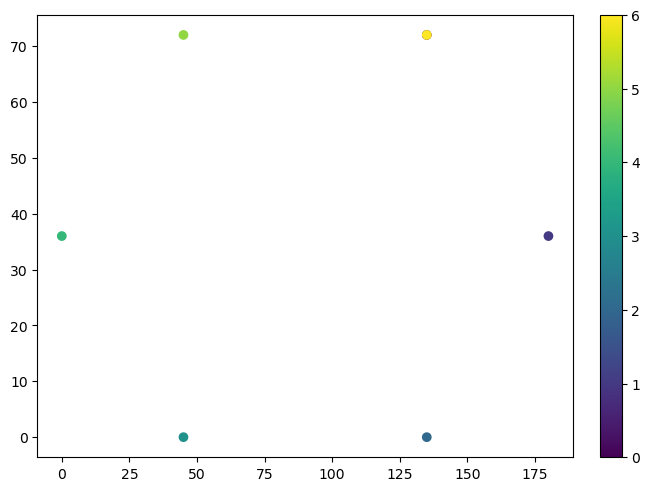

In [34]:
fig,ax = plt.subplots(nrows=1,ncols=1,constrained_layout=True)

deg_edge_lons = np.rad2deg(ds.lonEdge.isel(nEdges = sorted_edges))
deg_edge_lats = np.rad2deg(ds.latEdge.isel(nEdges = sorted_edges))

a = ax.scatter(deg_edge_lons, deg_edge_lats,c=np.arange(0,len(sorted_edges)))
fig.colorbar(a)

In [121]:
# test if basic algorithm works
target_lons = np.array([90,90,180])
target_lats = np.array([-18,90,18])
test_edges, test_vertices = mps.calculate_transects_multiple_pts(target_lons, target_lats, ds)

xr_end_vertex is  9
broken because reached end vertex
xr_end_vertex is  6
broken because reached end vertex
xr_end_vertex is  3
broken because reached end vertex


In [122]:
# test if basic algorithm works to create a bad mask
# we want a mask that will cross over itself
## this set doesn't work, which is what you should use to test it
target_lons = np.array([90,180,180,270,180,75,0])
target_lats = np.array([75,60,25,-25,25,-25,25])

# ## but first test this set, which travels to one point further??
# target_lons = np.array([180,180,270,270,180,75,0])
# target_lats = np.array([60,25,-25,-50,25,-25,25])

test_edges, test_vertices = mps.calculate_transects_multiple_pts(target_lons, target_lats, ds)

# then you have to sort these vertices
sorted_edges, sorted_vertices = mps.sorted_transect_edges_and_vertices(ds, test_edges, test_vertices)

xr_end_vertex is  8
broken because reached end vertex
xr_end_vertex is  6
broken because reached end vertex
xr_end_vertex is  4
broken because reached end vertex
xr_end_vertex is  6
broken because reached end vertex
xr_end_vertex is  3
broken because reached end vertex
xr_end_vertex is  5
broken because reached end vertex
xr_end_vertex is  9
broken because reached end vertex


ValueError: operands could not be broadcast together with shapes (6,) (2,) 

In [72]:
xr_mask_transect_edges = test_edges
xr_mask_transect_vertices = test_vertices

# ----------- SORT THE EDGES IN XR_MASK_EDGES -----------
xr_startEdge = np.int32(xr_mask_transect_edges[0])
n_startVertex = ds.verticesOnEdge.isel(nEdges=xr_startEdge)[0]
xr_startVertex = mps.n_to_xr_idx(n_startVertex)

remaining_edges = xr_mask_transect_edges[~np.isin(xr_mask_transect_edges, xr_startEdge)]
remaining_vertices = xr_mask_transect_vertices[~np.isin(xr_mask_transect_vertices, xr_startVertex)]
next_edges = np.array([xr_startEdge])
next_vertices = np.array([xr_startVertex])

In [120]:
# ----------- SORT THE EDGES IN XR_MASK_EDGES -----------
xr_startEdge = np.int32(xr_mask_transect_edges[0])
n_startVertex = ds.verticesOnEdge.isel(nEdges=xr_startEdge)[0]
xr_startVertex = mps.n_to_xr_idx(n_startVertex)

remaining_edges = xr_mask_transect_edges[~np.isin(xr_mask_transect_edges, xr_startEdge)]
remaining_vertices = xr_mask_transect_vertices[~np.isin(xr_mask_transect_vertices, xr_startVertex)]

next_edges = np.array([xr_startEdge])
next_vertices = np.array([xr_startVertex])
counter = 0

while len(remaining_edges)>0:
    # from the start vertex, find the edge attached to it s.t. the edge is also part of xr_mask_edges
    n_edgesOnStartVertex = ds.edgesOnVertex.isel(nVertices = xr_startVertex)
    xr_edgesOnStartVertex = mps.n_to_xr_idx(n_edgesOnStartVertex)
    
    xr_nextEdge = np.intersect1d(xr_edgesOnStartVertex, remaining_edges)
    if xr_nextEdge.size==0:
        break
    if xr_nextEdge.size > 1: # this should only even happen if you create a mask from a transect. a mask from a mask should not encounter this problem
        # # if xr_nextEdge.size > 1, then this means the transect will cross over itself & revisit the current vertex
        # # in which case, we want to delete all values that fall between when the transect reaches the crossing vertex and when it returns to the crossing vertex
        
        # # find the index for when the crossing vertex is repeated in remaining_vertices
        # xr_startVertex_2nd_index = np.where(np.isin(remaining_vertices, xr_startVertex))[0][1] # 0 chooses the first array, 1 chooses the second time the vertex is crossed. if 0 instead of 1, we would get the initial crossing instead

        # # remove all values between the current index and xr_nextEdge_index
        # remaining_edges = np.delete(remaining_edges, np.arange(1,xr_startVertex_2nd_index))
        # remaining_vertices = np.delete(remaining_vertices, np.arange(1,xr_startVertex_2nd_index))

        # # find the new start edge
        # xr_nextEdge = np.intersect1d(xr_edgesOnStartVertex, remaining_edges)
        xr_nextEdge = 
        
    # get the vertex that is not the previous vertex
    n_nextVertices = ds.verticesOnEdge.isel(nEdges = np.int32(xr_nextEdge))
    xr_nextVertices_raw = mps.n_to_xr_idx(n_nextVertices)
    xr_nextVertices = np.int32(xr_nextVertices_raw)
    
    xr_nextVertex_raw = xr_nextVertices[np.isin(xr_nextVertices, remaining_vertices)]
    xr_nextVertex = np.int32(xr_nextVertex_raw) 
    

    # stop if the next identified edge is not in the remaining edges (this means the rest of the remaining edges 
    # are islands or closed loops  
    # update arrays
    next_edges = np.append(next_edges, xr_nextEdge)
    next_vertices = np.append(next_vertices, xr_nextVertex)

    # remove the first instance of this edge/vertex occurring
    # we need to maintain second, third, etc instances to know when to remove large sections that get repeated
    xr_nextEdge_index_in_remaining_edges = np.where(remaining_edges==xr_nextEdge)[0].min()
    remaining_edges = np.delete(remaining_edges, xr_nextEdge_index_in_remaining_edges)

    xr_nextVertex_index_in_remaining_vertices = np.where(remaining_vertices == xr_nextVertex)[0].min()
    remaining_vertices = np.delete(remaining_vertices, xr_nextVertex_index_in_remaining_vertices)
    
    # remaining_edges = remaining_edges[remaining_edges != xr_nextEdge]
    # remaining_vertices = remaining_vertices[remaining_vertices != xr_nextVertex]
    xr_startVertex = xr_nextVertex
    counter +=1

        

# add the start vertex (which was used twice as the start and end) onto the end as well
next_vertices = np.append(next_vertices,mps.n_to_xr_idx(n_startVertex)) 
next_edges = np.append(next_edges, np.int32(xr_mask_transect_edges[0]))


IndexError: index 1 is out of bounds for axis 0 with size 1

In [123]:
# ----------- SORT THE EDGES IN XR_MASK_EDGES -----------
xr_startEdge = np.int32(xr_mask_transect_edges[0])
n_startVertex = ds.verticesOnEdge.isel(nEdges=xr_startEdge)[0]
xr_startVertex = mps.n_to_xr_idx(n_startVertex)

remaining_edges = xr_mask_transect_edges[~np.isin(xr_mask_transect_edges, xr_startEdge)]
remaining_vertices = xr_mask_transect_vertices[~np.isin(xr_mask_transect_vertices, xr_startVertex)]

next_edges = np.array([xr_startEdge])
next_vertices = np.array([xr_startVertex])
counter = 0

while len(remaining_edges)>0:
    # from the start vertex, find the edge attached to it s.t. the edge is also part of xr_mask_edges
    n_edgesOnStartVertex = ds.edgesOnVertex.isel(nVertices = xr_startVertex)
    xr_edgesOnStartVertex = mps.n_to_xr_idx(n_edgesOnStartVertex)
    
    xr_nextEdge = np.intersect1d(xr_edgesOnStartVertex, remaining_edges)
    if xr_nextEdge.size==0:
        break
    else:
    
        # get the vertex that is not the previous vertex
        n_nextVertices = ds.verticesOnEdge.isel(nEdges = np.int32(xr_nextEdge))
        xr_nextVertices_raw = mps.n_to_xr_idx(n_nextVertices)
        xr_nextVertices = np.int32(xr_nextVertices_raw)
        
        xr_nextVertex_raw = xr_nextVertices[np.isin(xr_nextVertices, remaining_vertices)]
        xr_nextVertex = np.int32(xr_nextVertex_raw) 
        
    
        # stop if the next identified edge is not in the remaining edges (this means the rest of the remaining edges 
        # are islands or closed loops  
        # update arrays
        next_edges = np.append(next_edges, xr_nextEdge)
        next_vertices = np.append(next_vertices, xr_nextVertex)
        remaining_edges = remaining_edges[remaining_edges != xr_nextEdge]
        remaining_vertices = remaining_vertices[remaining_vertices != xr_nextVertex]
        xr_startVertex = xr_nextVertex
        counter +=1

        

# add the start vertex (which was used twice as the start and end) onto the end as well
next_vertices = np.append(next_vertices,n_to_xr_idx(n_startVertex)) 
next_edges = np.append(next_edges, np.int32(xr_mask_transect_edges[0]))


ValueError: operands could not be broadcast together with shapes (6,) (2,) 

In [ ]:
test_edges

In [ ]:
xr_nextEdge

In [ ]:
remaining_edges

In [ ]:
fig,ax = plt.subplots(nrows=1,ncols=1,constrained_layout=True)

deg_edge_lons = np.rad2deg(ds.lonEdge.isel(nEdges = sorted_edges))
deg_edge_lats = np.rad2deg(ds.latEdge.isel(nEdges = sorted_edges))

a = ax.scatter(deg_edge_lons, deg_edge_lats,c=np.arange(0,len(sorted_edges)),alpha=0.5)
fig.colorbar(a)